In [1]:
pip install pyspark

In [2]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, desc, when, count

In [100]:
spark = SparkSession.builder.appName("ProjetAccidents").getOrCreate()

carac_files = ["drive//MyDrive//accidents//caracteristiques_2011.csv", "drive//MyDrive//accidents//caracteristiques_2012.csv", "drive//MyDrive//accidents//caracteristiques_2013.csv", "drive//MyDrive//accidents//caracteristiques_2014.csv", "drive//MyDrive//accidents//caracteristiques_2015.csv", "drive//MyDrive//accidents//caracteristiques_2016.csv", "drive//MyDrive//accidents//caracteristiques_2017.csv", "drive//MyDrive//accidents//caracteristiques_2018.csv", ]
lieux_files = ["drive//MyDrive//accidents//lieux_2011.csv", "drive//MyDrive//accidents//lieux_2012.csv", "drive//MyDrive//accidents//lieux_2013.csv", "drive//MyDrive//accidents//lieux_2014.csv", "drive//MyDrive//accidents//lieux_2015.csv", "drive//MyDrive//accidents//lieux_2016.csv", "drive//MyDrive//accidents//lieux_2017.csv", "drive//MyDrive//accidents//lieux_2018.csv"]
vehic_files = ["drive//MyDrive//accidents//vehicules_2011.csv", "drive//MyDrive//accidents//vehicules_2012.csv", "drive//MyDrive//accidents//vehicules_2013.csv", "drive//MyDrive//accidents//vehicules_2014.csv", "drive//MyDrive//accidents//vehicules_2015.csv", "drive//MyDrive//accidents//vehicules_2016.csv", "drive//MyDrive//accidents//vehicules_2017.csv", "drive//MyDrive//accidents//vehicules_2018.csv"]
usage_files = ["drive//MyDrive//accidents//usagers_2011.csv", "drive//MyDrive//accidents//usagers_2012.csv", "drive//MyDrive//accidents//usagers_2013.csv", "drive//MyDrive//accidents//usagers_2014.csv", "drive//MyDrive//accidents//usagers_2015.csv", "drive//MyDrive//accidents//usagers_2016.csv", "drive//MyDrive//accidents//usagers_2017.csv", "drive//MyDrive//accidents//usagers_2018.csv"]

#charger csv
dataframes_carac = [spark.read.csv(file_name, header=True, inferSchema=True) for file_name in carac_files]
dataframes_lieux = [spark.read.csv(file_name, header=True, inferSchema=True) for file_name in lieux_files]
dataframes_vehic = [spark.read.csv(file_name, header=True, inferSchema=True) for file_name in vehic_files]
dataframes_usage = [spark.read.csv(file_name, header=True, inferSchema=True) for file_name in usage_files]

#on cree une fct pour pouvoir fusionner les df entre eux
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

#fusion des df
df_carac = unionAll(*dataframes_carac)
df_lieux = unionAll(*dataframes_lieux)
df_vehic = unionAll(*dataframes_vehic)
df_usage = unionAll(*dataframes_usage)

df_carac = df_carac.coalesce(1)
df_lieux = df_lieux.coalesce(1)
df_vehic = df_vehic.coalesce(1)
df_usage = df_usage.coalesce(1)

In [101]:
#objectif : graphe des victimes par accident par gravité et catégorie de route
#utilisation de jointures
df_victimes = df_usage

df_accidents_victimes = df_victimes.join(
    df_lieux,
    df_victimes["Num_Acc"] == df_lieux["Num_Acc"],
    "inner"
).join(
    df_carac,
    df_lieux["Num_Acc"] == df_carac["Num_Acc"],
    "inner"
)


df_victimes_par_categorie_route = df_accidents_victimes.groupBy("catr", "grav").count()
df_accidents_par_categorie_route = df_lieux.groupBy("catr").count()
df_accidents_par_categorie_route = df_accidents_par_categorie_route.withColumnRenamed("count", "accidents_count")


df_combined = df_victimes_par_categorie_route.alias("victimes").join(
    df_accidents_par_categorie_route.alias("accidents"),
    col("victimes.catr") == col("accidents.catr"),
    "inner"
)

df_combined = df_victimes_par_categorie_route.alias("victimes").join(
    df_accidents_par_categorie_route.alias("accidents"),
    col("victimes.catr") == col("accidents.catr"),
    "inner"
)

#calcul proportion gravité
df_combined = df_combined.withColumn(
    "proportion_gravite",
    col("victimes.count") / col("accidents.accidents_count")
)

df_combined = df_combined.select("victimes.catr", "proportion_gravite", "victimes.grav", "accidents.accidents_count")
df_combined_filtered = df_combined.filter((col("victimes.catr") >= 1) & (col("victimes.catr") <= 4))

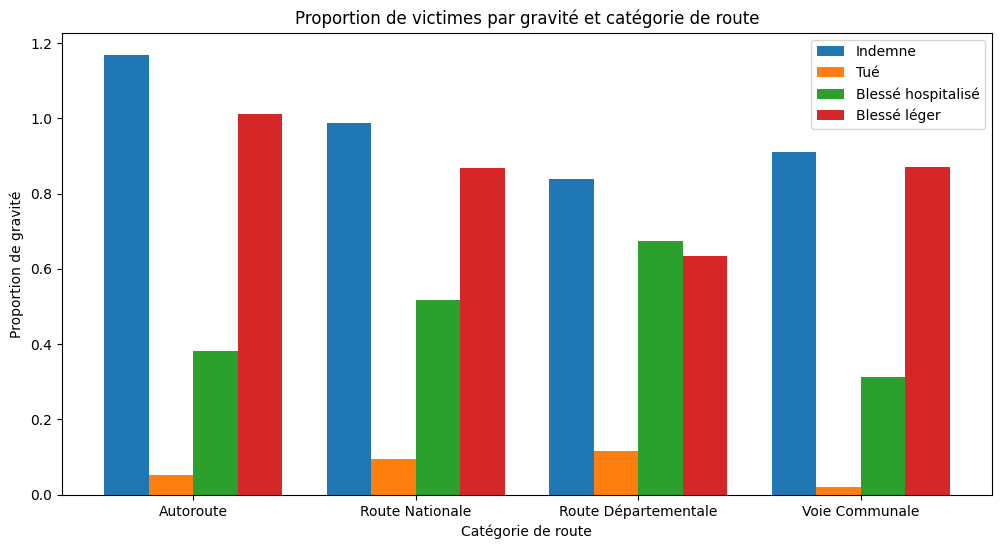

In [102]:
df_combined_pd = df_combined_filtered.toPandas()

catr_labels = [
    'Autoroute',
    'Route Nationale',
    'Route Départementale',
    'Voie Communale'
]

grav_labels = [
    'Indemne',
    'Tué',
    'Blessé hospitalisé',
    'Blessé léger'
]


grouped_data = df_combined_pd.groupby(['catr', 'grav'])['proportion_gravite'].sum().unstack()
catr_indices = np.arange(len(catr_labels))

plt.figure(figsize=(12, 6))
bar_width = 0.2

for i, (grav, data) in enumerate(grouped_data.items()):
    plt.bar(catr_indices + i * bar_width, data, width=bar_width, label=f'{grav_labels[int(grav) - 1]}')

plt.xlabel('Catégorie de route')
plt.ylabel('Proportion de gravité')
plt.title('Proportion de victimes par gravité et catégorie de route')
plt.xticks(catr_indices + 1.5 * bar_width, catr_labels)
plt.legend()
plt.show()

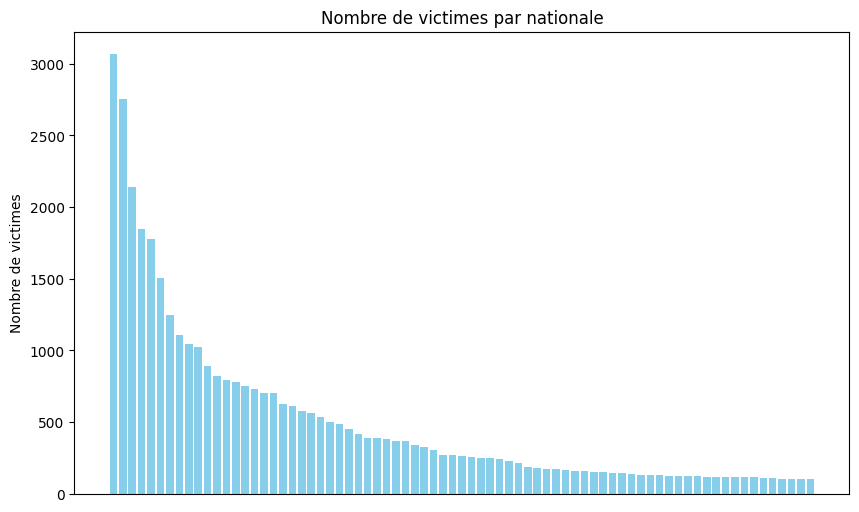

In [112]:
#calculer le nombre de victimes par route nationale
df_accidents_nationales = df_lieux.filter(col('catr') == '2')
df_victimes_nationales = df_usage.filter(col("grav") !='4')

df_accidents_victimes_nationales = df_victimes_nationales.join(
    df_accidents_nationales,
    df_victimes_nationales["Num_Acc"] == df_accidents_nationales["Num_Acc"],
    "inner"
)

df_victimes_par_nationale = df_accidents_victimes_nationales.groupBy("voie").count()
df_victimes_par_nationale = df_victimes_par_nationale.orderBy(desc('count'))

df_victimes_par_nationale = df_victimes_par_nationale.filter(col("count") > 100)
df_victimes_par_nationale = df_victimes_par_nationale.dropna(subset=['voie'])


#graphe
df_victimes_par_nationale_pd = df_victimes_par_nationale.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_victimes_par_nationale_pd['voie'], df_victimes_par_nationale_pd['count'], color='skyblue')
plt.ylabel('Nombre de victimes')
plt.title('Nombre de victimes par nationale')
plt.xticks([])
plt.show()

In [10]:
df_accidents_nationales = df_lieux.filter(col('catr') == '2')
df_morts_nationales = df_usage.filter(col("grav") == 2)

df_accidents_morts_nationales = df_morts_nationales.join(
    df_accidents_nationales,
    df_morts_nationales["Num_Acc"] == df_accidents_nationales["Num_Acc"],
    "inner"
)

df_morts_par_nationale = df_accidents_morts_nationales.groupBy("voie").count()
df_morts_par_nationale_filtered = df_morts_par_nationale.filter(col("count") > 20)
df_morts_par_nationale_filtered = df_morts_par_nationale_filtered.orderBy(desc('count'))

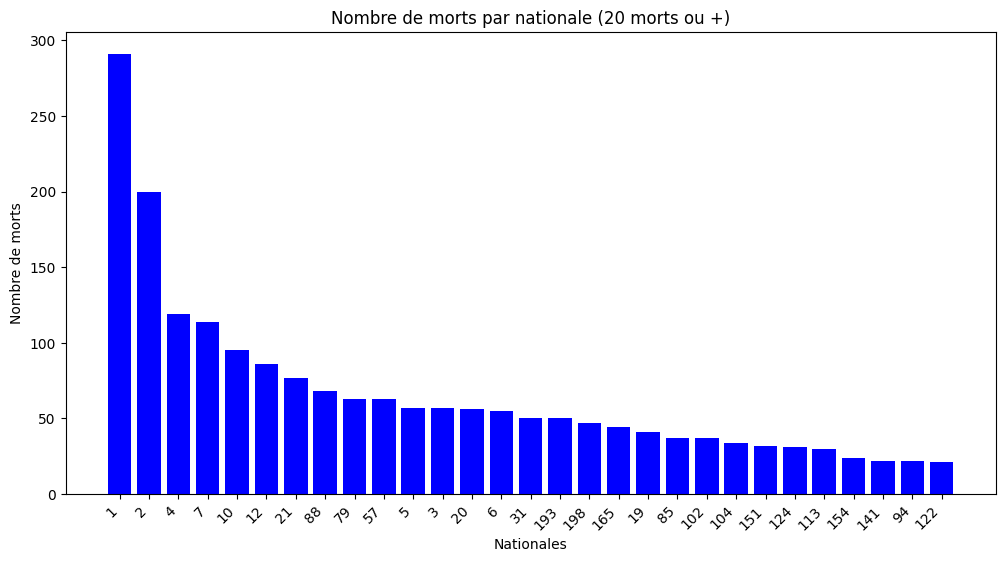

In [113]:
df_morts_par_nationale_filtered = df_morts_par_nationale_filtered.dropna(subset=['voie', 'count'])
df_morts_par_nationale_filtered = df_morts_par_nationale_filtered.withColumn("voie", df_morts_par_nationale_filtered["voie"].cast("string"))


df_morts_par_nationale_pd = df_morts_par_nationale_filtered.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(df_morts_par_nationale_pd['voie'], df_morts_par_nationale_pd['count'], color='blue')
plt.xlabel('Nationales')
plt.ylabel('Nombre de morts')
plt.title('Nombre de morts par nationale (20 morts ou +)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [114]:
#obtenir la proportion de morts par accident par nationale
df_accidents_par_nationale = df_accidents_nationales.groupBy("voie").count()
df_accidents_par_nationale = df_accidents_par_nationale.withColumnRenamed("count", "accidents_count")

df_combined = df_accidents_par_nationale.join(df_morts_par_nationale, "voie")

df_combined = df_combined.withColumn("proportion_morts_par_accident", col("count") / col("accidents_count"))

df_combined_filtered = df_combined.filter(col("count") > 10)

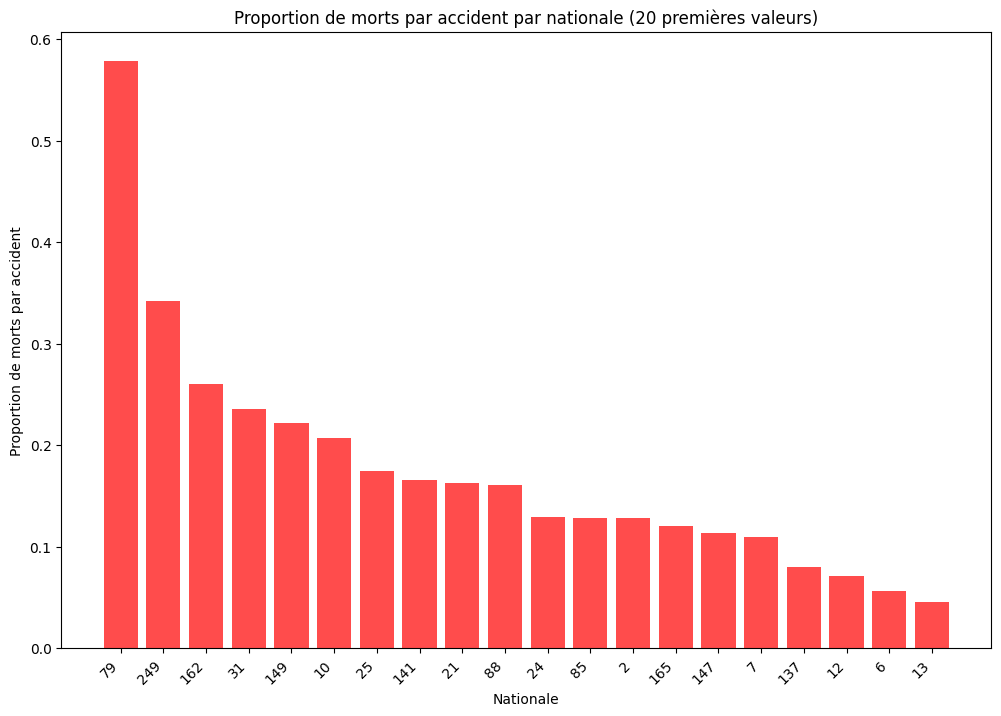

In [115]:
df_pandas = df_combined_filtered.limit(20).toPandas()
df_pandas = df_pandas.sort_values(by=['proportion_morts_par_accident'], ascending=False)

#histogramme
plt.figure(figsize=(12, 8))
plt.bar(df_pandas['voie'], df_pandas['proportion_morts_par_accident'], color='r', alpha=0.7)
plt.xlabel('Nationale')
plt.ylabel('Proportion de morts par accident')
plt.title('Proportion de morts par accident par nationale (20 premières valeurs)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
#CAS NATIONALE 79

In [116]:
#afficher les accidents sur une map
df_combined = df_lieux.join(df_carac, "Num_Acc")
df_79 = df_combined.filter(col("voie") == 79)

df_coordinates_79 = df_79.select("lat", "long")
df_coordinates_79 = df_coordinates_79.filter((col("lat") != 0) & (col("long") != 0))

df_coordinates_79 = df_coordinates_79.withColumn("lat_decimal", F.col("lat") / 100000)
df_coordinates_79 = df_coordinates_79.withColumn("long_decimal", F.col("long") / 100000)

latitude_charolles = 46.43546037536817
longitude_charolles = 4.275992109248168

map_79 = folium.Map(location=[latitude_charolles, longitude_charolles], zoom_start=12)

for _, row in df_coordinates_79.toPandas().iterrows():
    folium.Marker(
        location=[row['lat_decimal'], row['long_decimal']],
        icon=folium.Icon(color='red')
    ).add_to(map_79)

map_79

In [17]:
#verification des types de gravite sur la N79
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))
df_accidents_victimes_79 = df_accidents_79.join(
    df_usage,
    df_accidents_79["Num_Acc"] == df_usage["Num_Acc"],
    "inner"
)
df_victimes_par_gravite_79 = df_accidents_victimes_79.groupBy("grav").count()
df_victimes_par_gravite_79.show()

+----+-----+
|grav|count|
+----+-----+
|   1|  223|
|   2|   63|
|   3|  128|
|   4|   70|
+----+-----+



In [18]:
#creation de la colonne age et categorie_age
annee_actuelle = 2023
df_usage = df_usage.withColumn("age_conducteur", annee_actuelle - df_usage["an_nais"])
bins = [18, 25, 35, 45, 55, 65, 75, float('inf')]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
df_usage = df_usage.withColumn("categorie_age", F.when(F.col("age_conducteur").isNotNull(), F.when(F.col("age_conducteur") >= 75, '75+').otherwise(F.expr("CASE WHEN age_conducteur >= 65 THEN '65-74' WHEN age_conducteur >= 55 THEN '55-64' WHEN age_conducteur >= 45 THEN '45-54' WHEN age_conducteur >= 35 THEN '35-44' WHEN age_conducteur >= 25 THEN '25-34' WHEN age_conducteur >= 18 THEN '18-24' ELSE 'Unknown' END"))).otherwise('Unknown'))
accidents_par_age = df_usage.groupBy("categorie_age").count().orderBy("categorie_age")

In [22]:
#age des victimes
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))
df_victimes_route_79 = df_accidents_79.join(
    df_usage,
    df_accidents_79["Num_Acc"] == df_usage["Num_Acc"],
    "inner"
)
victimes_par_age_route_79 = df_victimes_route_79.groupBy("categorie_age").count().orderBy("categorie_age")

+-------------+-----+
|categorie_age|count|
+-------------+-----+
|        18-24|   78|
|        25-34|   72|
|        35-44|   65|
|        45-54|   82|
|        55-64|   89|
|        65-74|   52|
|          75+|   31|
|      Unknown|   15|
+-------------+-----+



In [26]:
#nombre de morts parge categorie d'age
voies_nationales = ['79', '249', '162', '31', '149', '10']

dfs_par_nationale = []

for voie in voies_nationales:
    df_accidents_nationale = df_lieux.filter(col('voie') == voie)
    df_victimes_nationale = df_accidents_nationale.join(
        df_usage,
        df_accidents_nationale["Num_Acc"] == df_usage["Num_Acc"],
        "inner"
    )
    victimes_par_age_nationale = df_victimes_nationale.groupBy("voie", "categorie_age").count().withColumnRenamed("count", "count_" + voie)
    dfs_par_nationale.append(victimes_par_age_nationale)

df_resultat = dfs_par_nationale[0]
for df_nationale in dfs_par_nationale[1:]:
    df_resultat = df_resultat.join(df_nationale, on=["voie", "categorie_age"], how="outer")

df_resultat = df_resultat.na.fill(0)

colonnes_count = ['count_79', 'count_249', 'count_162', 'count_31', 'count_149', 'count_10']

df_resultat = df_resultat.withColumn('total_count', sum(col(col_name) for col_name in colonnes_count))

df_resultat = df_resultat.select('voie', 'categorie_age', 'total_count')

df_resultat.show()

+----+-------------+-----------+
|voie|categorie_age|total_count|
+----+-------------+-----------+
|  10|        18-24|        513|
|  10|        25-34|       1667|
|  10|        35-44|       1671|
|  10|        45-54|       1466|
|  10|        55-64|       1294|
|  10|        65-74|        797|
|  10|          75+|        790|
|  10|      Unknown|        350|
| 149|        18-24|         34|
| 149|        25-34|        158|
| 149|        35-44|        117|
| 149|        45-54|         94|
| 149|        55-64|         80|
| 149|        65-74|         63|
| 149|          75+|         70|
| 149|      Unknown|         27|
| 162|        18-24|         51|
| 162|        25-34|        218|
| 162|        35-44|        154|
| 162|        45-54|        118|
+----+-------------+-----------+
only showing top 20 rows



In [27]:
from pyspark.sql.window import Window
#proportions d'ages
df_resultat = df_resultat.withColumn('proportion_age', F.col('total_count') / F.sum('total_count').over(Window.partitionBy('voie')))
df_resultat.show()

+----+-------------+-----------+--------------------+
|voie|categorie_age|total_count|      proportion_age|
+----+-------------+-----------+--------------------+
|  10|        18-24|        513|  0.0600140383715489|
|  10|        25-34|       1667|  0.1950163781001404|
|  10|        35-44|       1671| 0.19548432381843706|
|  10|        45-54|       1466| 0.17150210575573233|
|  10|        55-64|       1294|  0.1513804398689752|
|  10|        65-74|        797| 0.09323818437061301|
|  10|          75+|        790| 0.09241927936359383|
|  10|      Unknown|        350| 0.04094525035095929|
| 149|        18-24|         34| 0.05287713841368585|
| 149|        25-34|        158| 0.24572317262830481|
| 149|        35-44|        117| 0.18195956454121306|
| 149|        45-54|         94| 0.14618973561430793|
| 149|        55-64|         80| 0.12441679626749612|
| 149|        65-74|         63| 0.09797822706065319|
| 149|          75+|         70|  0.1088646967340591|
| 149|      Unknown|        

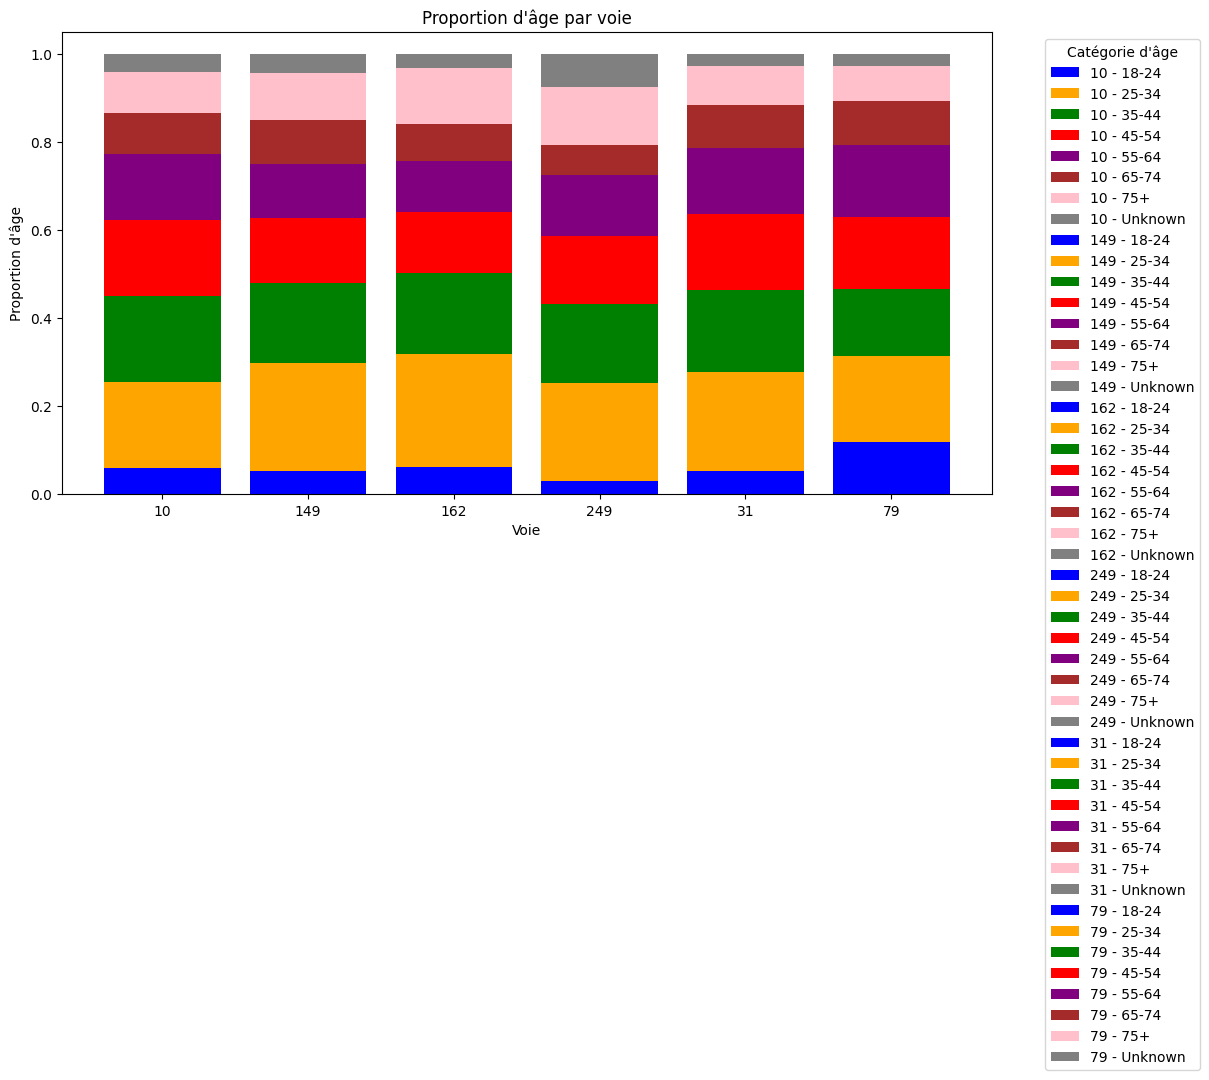

In [39]:
df_pandas = df_resultat.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'18-24': 'blue', '25-34': 'orange', '35-44': 'green', '45-54': 'red',
          '55-64': 'purple', '65-74': 'brown', '75+': 'pink', 'Unknown': 'gray'}

for voie in df_pandas['voie'].unique():
    data = df_pandas[df_pandas['voie'] == voie]
    bottom = 0
    for categorie_age in df_pandas['categorie_age'].unique():
        data_categorie_age = data[data['categorie_age'] == categorie_age]
        ax.bar(voie, data_categorie_age['proportion_age'], bottom=bottom, label=f'{voie} - {categorie_age}', color=colors[categorie_age])
        bottom += data_categorie_age['proportion_age'].values[0]

plt.xlabel('Voie')
plt.ylabel('Proportion d\'âge')
plt.title('Proportion d\'âge par voie')
plt.legend(title='Catégorie d\'âge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [59]:
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))

df_victimes_route_79 = df_accidents_79.join(
    df_usage,
    df_accidents_79["Num_Acc"] == df_usage["Num_Acc"],
    "inner"
)

df_victimes_route_79_ = df_victimes_route_79.filter(col('age_conducteur')==21)
df_victimes_route_79_.show()

#Calculer le nombre de jeunes permis victimes d'accidents
victimes_jeunes_permis_79 = df_victimes_route_79.filter(((col('catu') == 1) & (col('age_conducteur') == 18)) | ((col('catu') == 1) & (col('age_conducteur') == 19)) | ((col('catu') == 1) & (col('age_conducteur') == 20)))

#Afficher le résultat ZERO
victimes_jeunes_permis_79.show()

+------------+----+----+----+----+----+---+----+---+----+----+----+------+-------+----+-----+----+----+------------+-----+----+----+----+------+----+----+----+-----+-------+-------+--------------+-------------+
|     Num_Acc|catr|voie|  v1|  v2|circ|nbv|  pr|pr1|vosp|prof|plan|lartpc|larrout|surf|infra|situ|env1|     Num_Acc|place|catu|grav|sexe|trajet|secu|locp|actp|etatp|an_nais|num_veh|age_conducteur|categorie_age|
+------------+----+----+----+----+----+---+----+---+----+----+----+------+-------+----+-----+----+----+------------+-----+----+----+----+------+----+----+----+-----+-------+-------+--------------+-------------+
|201500018385|   2|  79|NULL|NULL|   2|  2|25.0|800|   0|   1|   1|     0|     76|   1|    0|   1|  99|201500018385|    4|   2|   1|   1|     0|  11|   0|   0|    0|   2002|    B02|            21|        18-24|
|201700018713|   2|  79|NULL|NULL|   3|  4|45.0|174|   0|   2|   3|     0|      0|   2|    0|   1|  99|201700018713|    8|   2|   1|   1|     9|  11|   0|  

In [62]:
#surfaces
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))
df_count_surf = df_accidents_79.groupBy("surf").count()
df_count_surf.show()

+----+-----+
|surf|count|
+----+-----+
|   2|   19|
|   7|    7|
|   1|   81|
|   0|    2|
+----+-----+



In [70]:
#obstacles rencontrés par les véhicules
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))
df_obstacles_79 = df_accidents_79.join(
    df_vehic,
    df_accidents_79["Num_Acc"] == df_vehic["Num_Acc"],
    "inner"
)

obs_mapping = {
    1: 'Véhicule en stationnement',
    2: 'Arbre',
    3: 'Glissière métallique',
    4: 'Glissière béton',
    5: 'Autre glissière',
    6: 'Bâtiment, mur, pile de pont',
    7: 'Support de signalisation verticale ou poste d’appel d’urgence',
    8: 'Poteau',
    9: 'Mobilier urbain',
    10: 'Parapet',
    11: 'Ilot, refuge, borne haute',
    12: 'Bordure de trottoir',
    13: 'Fossé, talus, paroi rocheuse',
    14: 'Autre obstacle fixe sur chaussée',
    15: 'Autre obstacle fixe sur trottoir ou accotement',
    16: 'Sortie de chaussée sans obstacle'
}

df1 = df_obstacles_79.groupBy("obs").count()
df1 = df1.withColumn('obs_description', F.expr('CASE ' + ' '.join([f'WHEN obs = {k} THEN "{v}"' for k, v in obs_mapping.items()]) + ' END'))
df1.show()

obsm_mapping = {
    1: 'Piéton',
    2: 'Véhicule',
    4: 'Véhicule sur rail',
    5: 'Animal domestique',
    6: 'Animal sauvage',
    9: 'Autre'
}

df2 = df_obstacles_79.groupBy("obsm").count()
df2 = df2.withColumn('obsm_description', F.expr('CASE ' + ' '.join([f'WHEN obsm = {k} THEN "{v}"' for k, v in obsm_mapping.items()]) + ' END'))
df2.show()

+---+-----+--------------------+
|obs|count|     obs_description|
+---+-----+--------------------+
|  0|  205|                NULL|
|  1|   10|Véhicule en stati...|
|  3|   18|Glissière métallique|
|  4|    3|     Glissière béton|
| 13|    4|Fossé, talus, par...|
| 11|    1|Ilot, refuge, bor...|
|  6|    2|Bâtiment, mur, pi...|
| 14|    2|Autre obstacle fi...|
|  2|    2|               Arbre|
| 15|    1|Autre obstacle fi...|
| 10|    1|             Parapet|
+---+-----+--------------------+

+----+-----+----------------+
|obsm|count|obsm_description|
+----+-----+----------------+
|   2|  185|        Véhicule|
|   0|   60|            NULL|
|   9|    2|           Autre|
|   1|    2|          Piéton|
+----+-----+----------------+



In [84]:
from pyspark.sql.functions import lit

compiled_df = df1.union(df2)

compiled_df_filtered = compiled_df.filter(compiled_df['obs_description'].isNotNull())
compiled_df_filtered = compiled_df_filtered.select('obs_description', 'count')

compiled_df_filtered = compiled_df_filtered.orderBy(desc('count'))

compiled_df_filtered.show()

+--------------------+-----+
|     obs_description|count|
+--------------------+-----+
|            Véhicule|  185|
|Glissière métallique|   18|
|Véhicule en stati...|   10|
|Fossé, talus, par...|    4|
|     Glissière béton|    3|
|               Autre|    2|
|Bâtiment, mur, pi...|    2|
|              Piéton|    2|
|Autre obstacle fi...|    2|
|               Arbre|    2|
|Ilot, refuge, bor...|    1|
|Autre obstacle fi...|    1|
|             Parapet|    1|
+--------------------+-----+



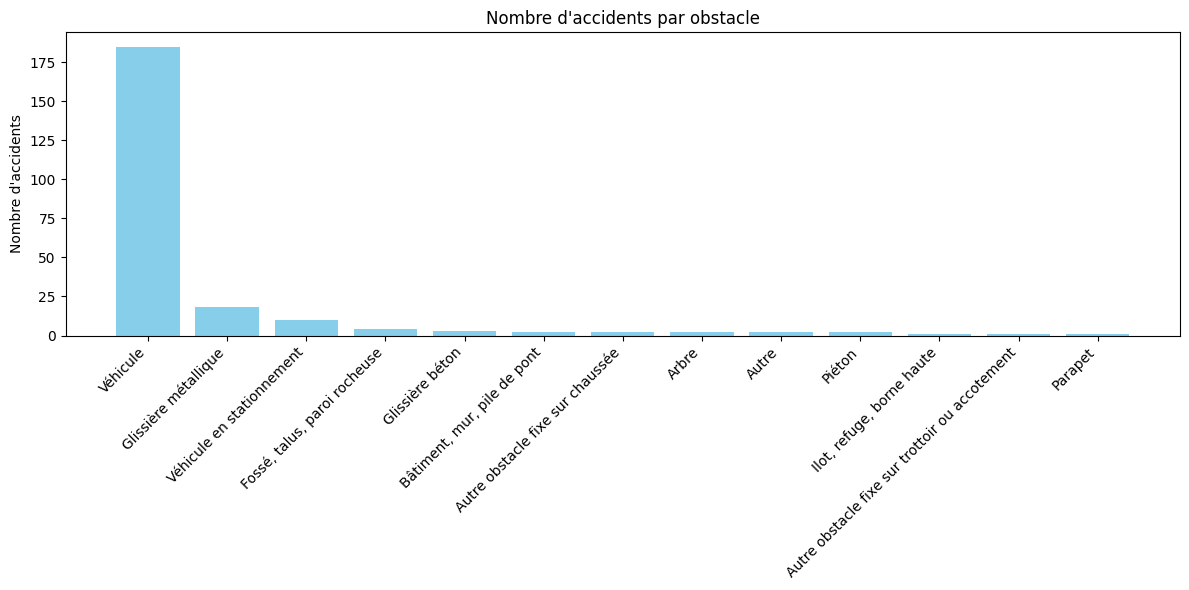

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

obs_df_pd = compiled_df_filtered.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(obs_df_pd['obs_description'], obs_df_pd['count'], color='skyblue')
plt.ylabel('Nombre d\'accidents')
plt.title('Nombre d\'accidents par obstacle')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [90]:
#manoeuvre principale avant l'accident
df_accidents_79 = df_lieux.filter((col('catr') == 2) & (col('voie') == 79))
df_accidents_79_voiture = df_accidents_79.join(
    df_vehic,
    df_accidents_79["Num_Acc"] == df_vehic["Num_Acc"],
    "inner"
)

df_accidents_79_voiture = df_accidents_79_voiture.filter(col('obsm')==2)
df_accidents_79_voiture.show()
df_choc_count = df_accidents_79_voiture.groupBy('manv').count()
df_choc_count.show()

+------------+----+----+----+----+----+---+----+---+----+----+----+------+-------+----+-----+----+----+------------+----+----+------+---+----+----+----+-------+
|     Num_Acc|catr|voie|  v1|  v2|circ|nbv|  pr|pr1|vosp|prof|plan|lartpc|larrout|surf|infra|situ|env1|     Num_Acc|senc|catv|occutc|obs|obsm|choc|manv|num_veh|
+------------+----+----+----+----+----+---+----+---+----+----+----+------+-------+----+-----+----+----+------------+----+----+------+---+----+----+----+-------+
|201100008501|   2|  79|NULL|NULL|   2|  0|34.0|500|   0|   1|   1|     0|     78|   2|    0|   1|  99|201100008501|   0|  17|     0|  0|   2|   3|   1|    B02|
|201100008501|   2|  79|NULL|NULL|   2|  0|34.0|500|   0|   1|   1|     0|     78|   2|    0|   1|  99|201100008501|   0|   7|     0|  0|   2|   3|  13|    A01|
|201100008510|   2|  79|NULL|NULL|   2|  2|35.0|  0|   0|   0|   1|     0|     81|   1|    0|   1|   0|201100008510|   0|   7|     0|  0|   2|   1|   1|    A01|
|201100008510|   2|  79|NULL|NULL|

In [98]:
df_choc_count = df_accidents_79_voiture.groupBy('manv').count()

total_count = df_choc_count.agg(F.sum('count')).collect()[0][0]

df_choc_count = df_choc_count.withColumn('proportion', F.col('count') / total_count)

df_choc_count = df_choc_count.filter(col('manv')!=0)
df_choc_count.show()

+----+-----+--------------------+
|manv|count|          proportion|
+----+-----+--------------------+
|   1|   89|  0.4810810810810811|
|  13|   40| 0.21621621621621623|
|  21|   13| 0.07027027027027027|
|  17|    3|0.016216216216216217|
|   2|   17|  0.0918918918918919|
|   5|    4|0.021621621621621623|
|   6|    1|0.005405405405405406|
|   3|    1|0.005405405405405406|
|  10|    1|0.005405405405405406|
|   9|    1|0.005405405405405406|
|  19|    1|0.005405405405405406|
|  24|    1|0.005405405405405406|
|  15|    1|0.005405405405405406|
|  11|    1|0.005405405405405406|
|  14|    2|0.010810810810810811|
|  12|    1|0.005405405405405406|
|  23|    3|0.016216216216216217|
+----+-----+--------------------+



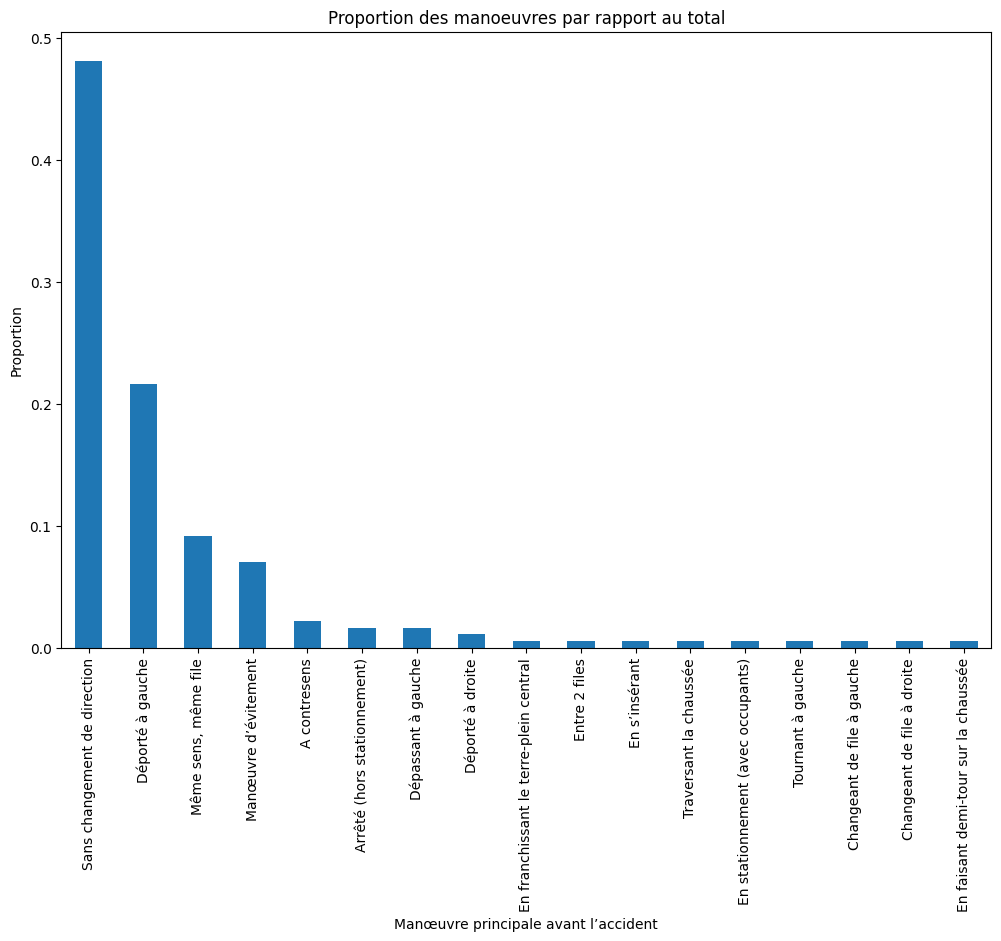

In [99]:
df_pandas = df_choc_count.toPandas()

manv_mapping = {
    1: "Sans changement de direction",
    2: "Même sens, même file",
    3: "Entre 2 files",
    4: "En marche arrière",
    5: "A contresens",
    6: "En franchissant le terre-plein central",
    7: "Dans le couloir bus, dans le même sens",
    8: "Dans le couloir bus, dans le sens inverse",
    9: "En s’insérant",
    10: "En faisant demi-tour sur la chaussée",
    11: "Changeant de file à gauche",
    12: "Changeant de file à droite",
    13: "Déporté à gauche",
    14: "Déporté à droite",
    15: "Tournant à gauche",
    16: "Tournant à droite",
    17: "Dépassant à gauche",
    18: "Dépassant à droite",
    19: "Traversant la chaussée",
    20: "Manœuvre de stationnement",
    21: "Manœuvre d’évitement",
    22: "Ouverture de porte",
    23: "Arrêté (hors stationnement)",
    24: "En stationnement (avec occupants)"
}

df_pandas['manv_description'] = df_pandas['manv'].map(manv_mapping)
df_pandas = df_pandas.sort_values(by='proportion', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
df_pandas.plot(kind='bar', x='manv_description', y='proportion', ax=ax, legend=False)

plt.xlabel('Manœuvre principale avant l’accident')
plt.ylabel('Proportion')
plt.title('Proportion des manoeuvres par rapport au total')
plt.show()

Conclusion :

- N79 beaucoup plus meurtrière que les autres routes
- Plusieurs pistes envisageables pour expliquer la mortalité chez les jeunes et les manoeuvres pré-accident
- Manque d'informations dans la base de données permettant de valider ou invalider ces pistes

Certaines pistes déjà non concluantes (météo, jeune permis par exemple, localisation sur la nationale)